In [252]:
import pandas as pd
import numpy as np
import xarray as xr
import pdb
import matplotlib.pyplot as plt
import cartopy
from utils import u_plot as up, u_darrays
import cartopy.crs as ccrs
import os
import matplotlib as mpl
import pickle as pkl
from utils import constants as cnst, u_darrays, u_grid, u_plot
from scipy.ndimage.measurements import label
import ipdb

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [273]:
ts = xr.open_mfdataset(cnst.CHIRPS + "*.nc")#"/global/chirps-v2.0.monthly.nc")
WA = [-15,15,4,9]
SA = [5,55,-40,0]

In [345]:
mean_years = ts.sel(longitude=slice(WA[0], WA[1]), latitude=slice(WA[2], WA[3]))

#mean_years = u_darrays.flip_lat(mean_years)
mean_years = (mean_years['rainfall'])[(mean_years['time.month']==3)]# & (mean_years['time.month']<=5)]

In [346]:
mean_years = u_darrays.to_newarray(mean_years)

In [347]:
np.percentile(mean_years.values[mean_years.values>1], 90)

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


12.834570121765136

In [348]:
#mean_years = mean_years.groupby('time.year').mean('time') mean rain trend
mean_years = mean_years.where((mean_years >= 12), other=0)
mean_years.values[mean_years.values>=12] = 1

In [349]:
mean_y = u_grid.refactor_da(mean_years, 0.25, method=np.max)

In [350]:
mean_y = mean_y.groupby('time.year').sum('time')

In [351]:
np.nanmax(mean_y.values)

26.0

In [352]:
mean_y

<xarray.DataArray (year: 35, latitude: 12, longitude: 75)>
array([[[0., 0., ..., 2., 3.],
        [0., 0., ..., 1., 2.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 4., 6.],
        [0., 0., ..., 4., 5.],
        ...,
        [0., 0., ..., 0., 1.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 7., 8.],
        [0., 0., ..., 3., 8.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 1., 2.],
        [0., 0., ..., 1., 2.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 4.15 4.55 4.95 5.35 ... 7.35 7.75 8.15 8.55
  * longitude  (longitude) float64 -14.85 -14.45 -14.05 ... 13.95 14.35 14.75
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2012 2013 2014 2015

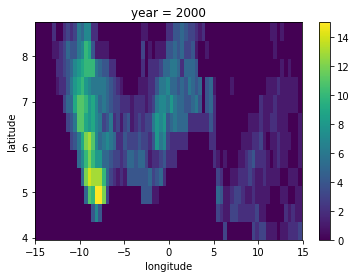

In [353]:
mean_y[19,:,:].plot.pcolormesh()

In [354]:
mean_y

<xarray.DataArray (year: 35, latitude: 12, longitude: 75)>
array([[[0., 0., ..., 2., 3.],
        [0., 0., ..., 1., 2.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 4., 6.],
        [0., 0., ..., 4., 5.],
        ...,
        [0., 0., ..., 0., 1.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 7., 8.],
        [0., 0., ..., 3., 8.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 1., 2.],
        [0., 0., ..., 1., 2.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 4.15 4.55 4.95 5.35 ... 7.35 7.75 8.15 8.55
  * longitude  (longitude) float64 -14.85 -14.45 -14.05 ... 13.95 14.35 14.75
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2012 2013 2014 2015

In [355]:
def calc_trend(mean_years, method='mk', sig=False):
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['latitude', 'longitude'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0
            
    return dtrend

In [356]:
trend=calc_trend(mean_y)

Entering trend calc


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [357]:
trend['slope'].values = trend['slope'].values*10

In [358]:
np.nanmin(trend['slope'].values)

-1.0336133959916236

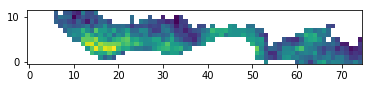

In [359]:
plt.figure()
plt.imshow(trend['slope'], origin='lower')

In [360]:
trend['slope'].values[trend['pval'].values>0.05] = 0

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [361]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(10,8), dpi=300)  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(),**kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        con = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='k', linewidths=0.5 )
        plt.clabel(con, inline=True, fontsize=7, fmt='%1.1f')
        
    if contour2 is not None:
        con = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], colors='r', linewidths=0.5 )
        plt.clabel(con, inline=True, fontsize=7, fmt='%1.1f')
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label) 
    f.canvas.draw()
    plt.tight_layout()
    #plt.savefig(cnst.network_data + 'figs/CLOVER/SA/CHIRPS_trend.pdf')

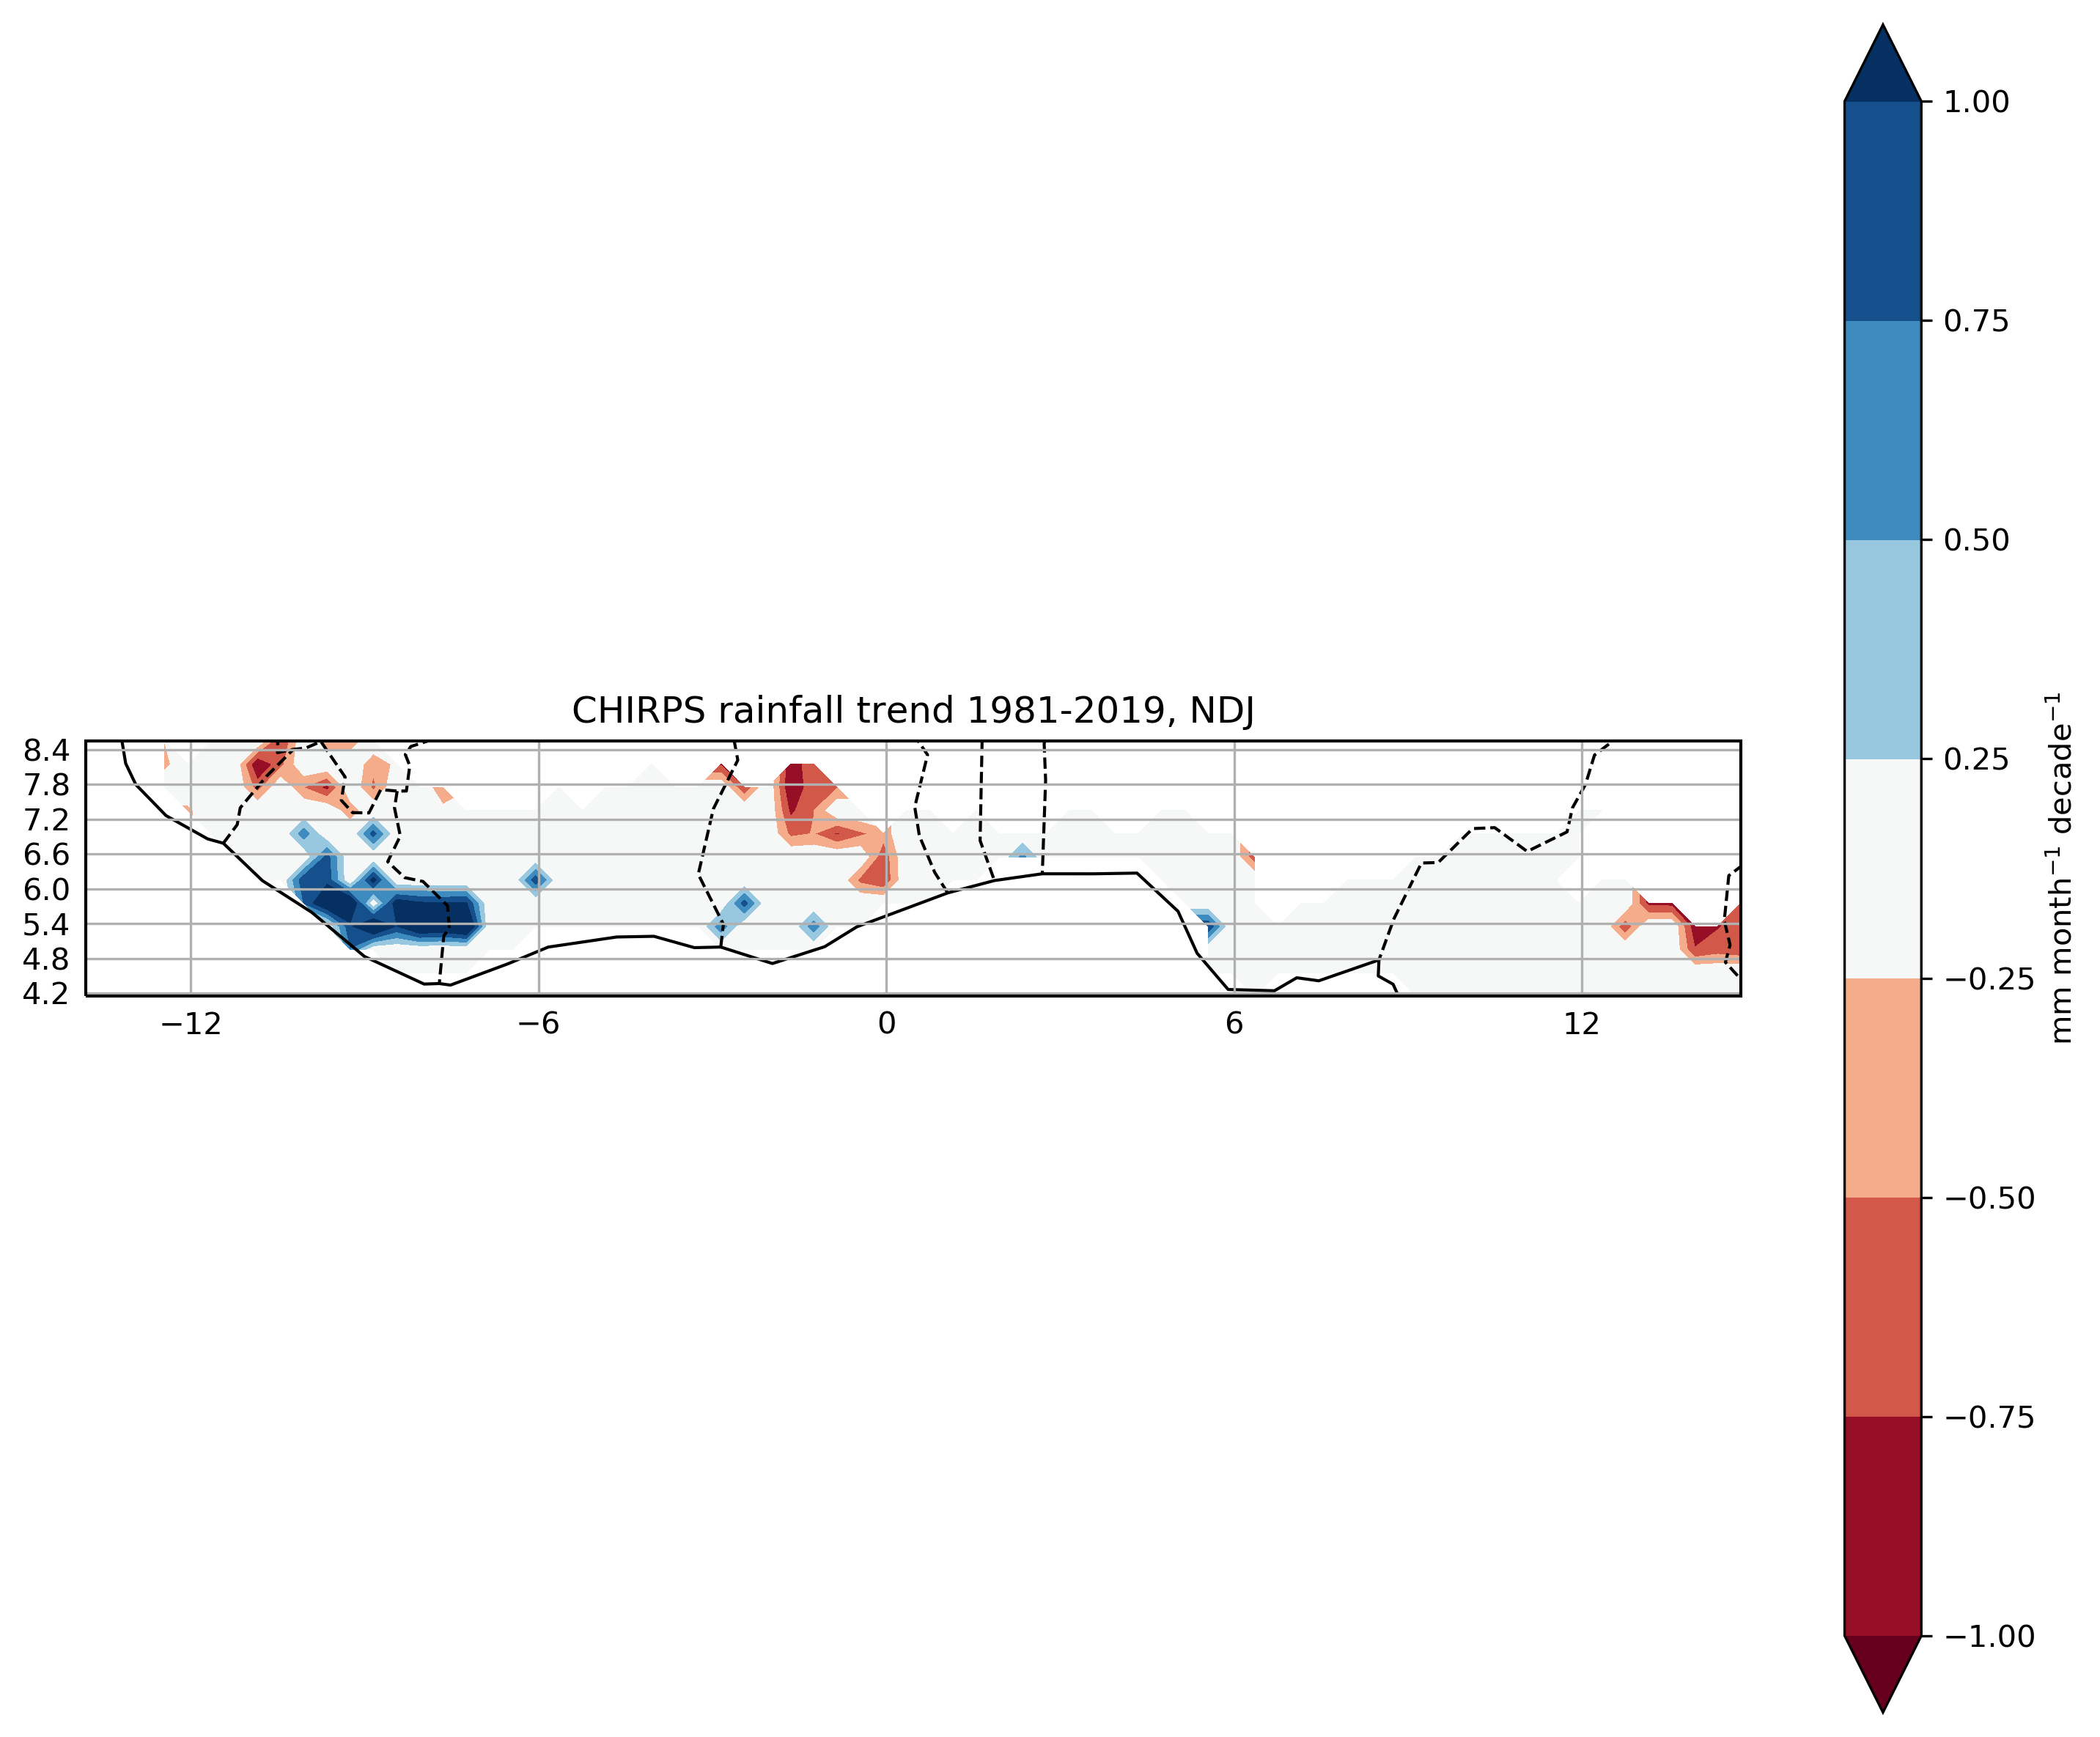

In [362]:
#contour = {'x' : mean_y['longitude'].values, 'y': mean_y['latitude'].values, 'data': clim, 'levels': np.linspace(50, 300, 5)}
#contour2 = {'x' : mean_y['longitude'].values, 'y': mean_y['latitude'].values, 'data': clim, 'levels': np.linspace(25, 75, 2)}
draw_map(trend['slope'], mean_y['longitude'].values, mean_y['latitude'].values, cmap='RdBu', extend='both', levels = [-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1] ,
        cbar_label='mm month$^{-1}$ decade$^{-1}$', title='CHIRPS rainfall trend 1981-2019, NDJ')  #[-10,-8,-6,-4,-2,2,4,6,8,10]